In [131]:
import json
import os
import pandas as pd


def load_data(file_path):
    """
    Load data from a JSON file.
    
    :param file_path: Path to the JSON file.
    :return: Parsed JSON data.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def get_results(data):
    results = {entry['id']: entry['response'] for entry in data}
    return results

def get_tokens(data):
    tokens = dict()
    for entry in data:
        if not isinstance(entry["tokens"], dict):
            tokens[entry['id']] = entry['tokens']
        else:
            tokens[entry['id']] = entry['tokens'].get('total_tokens', 0)
    return tokens

def get_gt(data):
    gt = {entry['id']: entry['is_blooming'] for entry in data}
    return gt

dfs = []
for file in os.listdir("results"):
    if file.endswith("850.json"):
        with open(os.path.join("results", file), 'r') as f:
            data = json.load(f)
        results = get_results(data)
        tokens = get_tokens(data)
        name = os.path.splitext(file)[0]
        dfs.append(pd.DataFrame.from_dict(results, orient='index', columns=[name]))

for file in os.listdir("ground_truth"):
    if "850" in file and file.endswith(".json"):
        with open(os.path.join("ground_truth", file), 'r') as f:
            data = json.load(f)
        gt = get_gt(data)
        name = os.path.splitext(file)[0]
        dfs.append(pd.DataFrame.from_dict(gt, orient='index', columns=[name]))

df = pd.concat(dfs, axis=1)
df.rename(columns={
    df.columns[0]: "LLM only",
    df.columns[1]: "Single Agent + Data",
    df.columns[2]: "Multi Agent + Data",
    df.columns[3]: "Apfel Agent",
    df.columns[4]: "Birke Agent",
    df.columns[5]: "Erle Agent",
    df.columns[6]: "Hasel Agent",
    df.columns[7]: "Winterraps Agent",
    df.columns[8]: "Winterroggen Agent",
    df.columns[9]: "Esche Agent",
    df.columns[10]: "Forsythie Agent",
    df.columns[11]: "Huflattich Agent",
    df.columns[12]: "Loewenzahn Agent",
    df.columns[13]: "Schneegloeckchen Agent",
    df.columns[14]: "Beifuss Agent",
    df.columns[15]: "Ground Truth Dev 0",
    df.columns[16]: "Ground Truth Dev 5",
    df.columns[17]: "Ground Truth Dev 10"
}, inplace=True)

In [132]:

df = df[:-250]

In [133]:
df["Birke Agent"]

0      no answer
1      no answer
2      no answer
3      no answer
4             no
         ...    
595    no answer
596    no answer
597    no answer
598           no
599    no answer
Name: Birke Agent, Length: 600, dtype: object

In [134]:
df.iloc[:, -3].values

array(['no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes',
       'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no',
       'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes',
       'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes',
       'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no',
       'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes',
       'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes',
       'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes',
       'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes',
       'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'no

In [135]:
expect_answer = {
    "Apfel Agent": (0,49),
    "Birke Agent": (50,99),
    "Erle Agent": (100,149),
    "Hasel Agent": (150,199),
    "Winterraps Agent": (200,249),
    "Winterroggen Agent": (250,299),
}

expect_answer = {
    "Apfel Agent": (0,49),
    "Birke Agent": (50,99),
    "Erle Agent": (100,149),
    "Hasel Agent": (150,199),
    "Winterraps Agent": (200,249),
    "Winterroggen Agent": (250,299),
}
df_filtered = df["Birke Agent"][(df.index < expect_answer["Birke Agent"][0]) | (df.index > expect_answer["Birke Agent"][1])] == "no answer"
df_filtered

0       True
1       True
2       True
3       True
4      False
       ...  
595     True
596     True
597     True
598    False
599     True
Name: Birke Agent, Length: 550, dtype: bool

In [136]:
class CustomDict(dict):
    """
    Custom dictionary class to handle missing keys gracefully.
    Returns a default value of 'no answer' for missing keys.
    """
    def __missing__(self, key):
        return "no answer"

expect_answer = {
    "Apfel Agent": (0,49),
    "Birke Agent": (50,99),
    "Erle Agent": (100,149),
    "Hasel Agent": (150,199),
    "Winterraps Agent": (200,249),
    "Winterroggen Agent": (250,299),
}


def make_comparison_matrix(df, pos):
    """
    Create a comparison matrix for the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        pos (int): The position of the ground truth column.

    Returns:
        pd.DataFrame: A comparison matrix.
    """
    comparison_matrix_0 = pd.DataFrame(
        {
            col: (
                (df[col].values == df.iloc[:, pos].values) |  # Compare with ground truth
                (
                    ((df.index < expect_answer[col][0]) | (df.index > expect_answer[col][1])) & (df[col] == "no answer")
                    if col in expect_answer.keys() else False  # Apply only if col is in expect_answer
                )
            )
            for col in df.columns[:-3]  # Exclude the last 3 columns (assumed to be ground truth)
        }
    )
    return comparison_matrix_0

comparison_matrix_0 = make_comparison_matrix(df, -3)
comparison_matrix_5 = make_comparison_matrix(df, -2)
comparison_matrix_10 = make_comparison_matrix(df, -1)

In [137]:
df_heatmap = pd.concat([comparison_matrix_0.sum(axis=0)/len(comparison_matrix_0), 
 comparison_matrix_5.sum(axis=0)/len(comparison_matrix_5), 
 comparison_matrix_10.sum(axis=0)/len(comparison_matrix_10)], axis=1)
df_heatmap.columns = ['0', '5', '10']
df_heatmap

,0,5,10
LLM only,0.530000,0.536667,0.538333
Single Agent + Data,0.476667,0.456667,0.450000
Multi Agent + Data,0.463333,0.443333,0.436667
Apfel Agent,0.871667,0.848333,0.843333
Birke Agent,0.900000,0.896667,0.895000
Erle Agent,0.766667,0.773333,0.776667
Hasel Agent,0.728333,0.728333,0.728333
Winterraps Agent,0.895000,0.886667,0.881667
Winterroggen Agent,0.901667,0.888333,0.886667
Esche Agent,0.001667,0.001667,0.001667


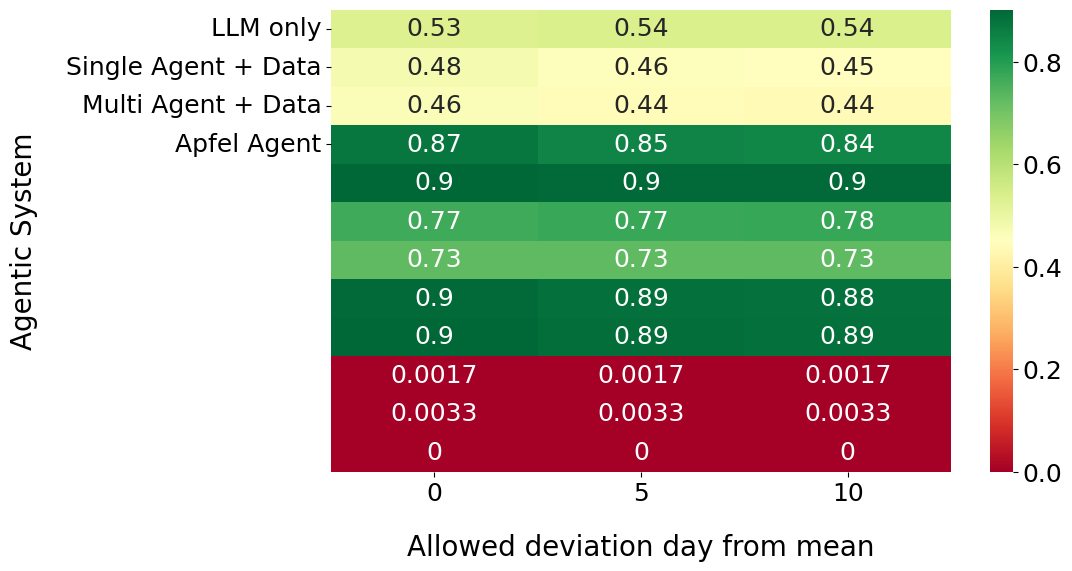

In [138]:



import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap[0:12], annot=True, cmap="RdYlGn", xticklabels=df_heatmap.columns[:4], yticklabels=df_heatmap.index[:4])
#plt.title("Comparison Heatmap: Predictions vs Ground Truth")
plt.xlabel("Allowed deviation day from mean", fontsize=20,labelpad=20)
plt.ylabel("Agentic System", fontsize=20, labelpad=20)
plt.show()

In [140]:
cm = comparison_matrix_10
cm = cm.groupby(cm.index // 50).sum()/50
cm.index = ["Apfel", "Birke", "Erle", "Hasel", "Winterraps", "Winterroggen", "Esche", "Forsythie", "Huflattich", "Loewenzahn", "Schneegloeckchen", "Beifuss"]# "Eichel", "Kastanie", "Linde", "Klatschmohn", "Raps"]
cm = cm.transpose()
cm = cm.iloc[:8, :5]

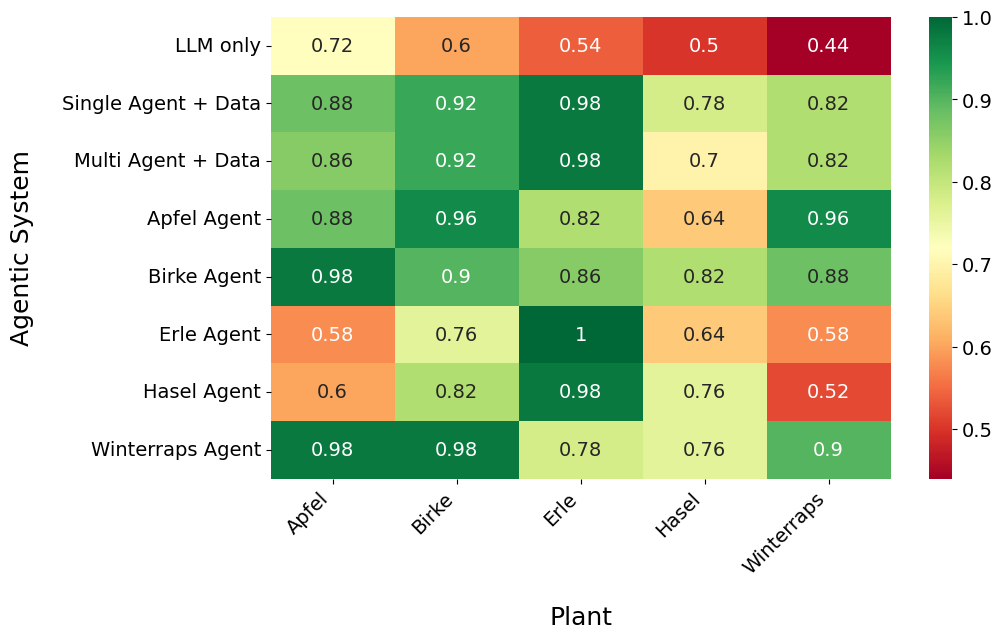

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap="RdYlGn", xticklabels=cm.columns, yticklabels=cm.index)
#plt.title("Comparison Heatmap: Predictions vs Ground Truth")
plt.xlabel("Plant", fontsize=18, labelpad=20)
plt.ylabel("Agentic System", fontsize=18, labelpad=20)
plt.xticks(rotation=45, ha='right')
plt.show()

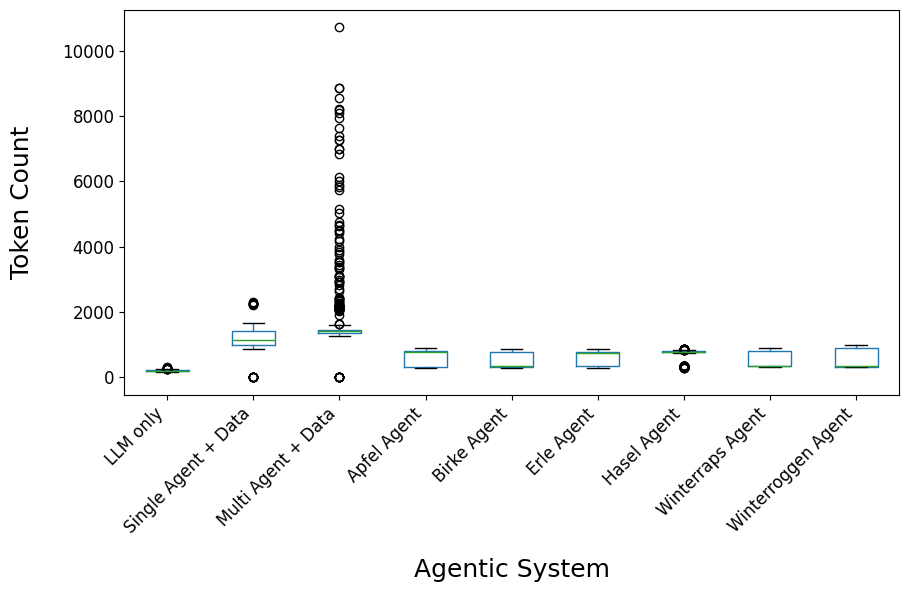

In [ ]:
import matplotlib.pyplot as plt
#token usage
plt.rcParams.update({'font.size': 12})

dfs = []
for file in os.listdir("results"):
    if file.endswith(".json") and "850" in file:
        with open(os.path.join("results", file), 'r') as f:
            data = json.load(f)
        tokens = get_tokens(data)
        name = os.path.splitext(file)[0]
        dfs.append(pd.DataFrame.from_dict(tokens, orient='index', columns=[name]))

df = pd.concat(dfs, axis=1)
df.rename(columns={
    df.columns[0]: "LLM only",
    df.columns[1]: "Single Agent + Data",
    df.columns[2]: "Multi Agent + Data",
    df.columns[3]: "Apfel Agent",
    df.columns[4]: "Birke Agent",
    df.columns[5]: "Erle Agent",
    df.columns[6]: "Hasel Agent",
    df.columns[7]: "Winterraps Agent",
    df.columns[8]: "Winterroggen Agent"
}, inplace=True)
df = df.iloc[:, :9]
df.boxplot(rot=90, figsize=(10, 5), grid=False)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 4000)
plt.ylabel("Token Count", fontsize=18, labelpad=20)
plt.xlabel("Agentic System", fontsize=18, labelpad=15)
plt.show()


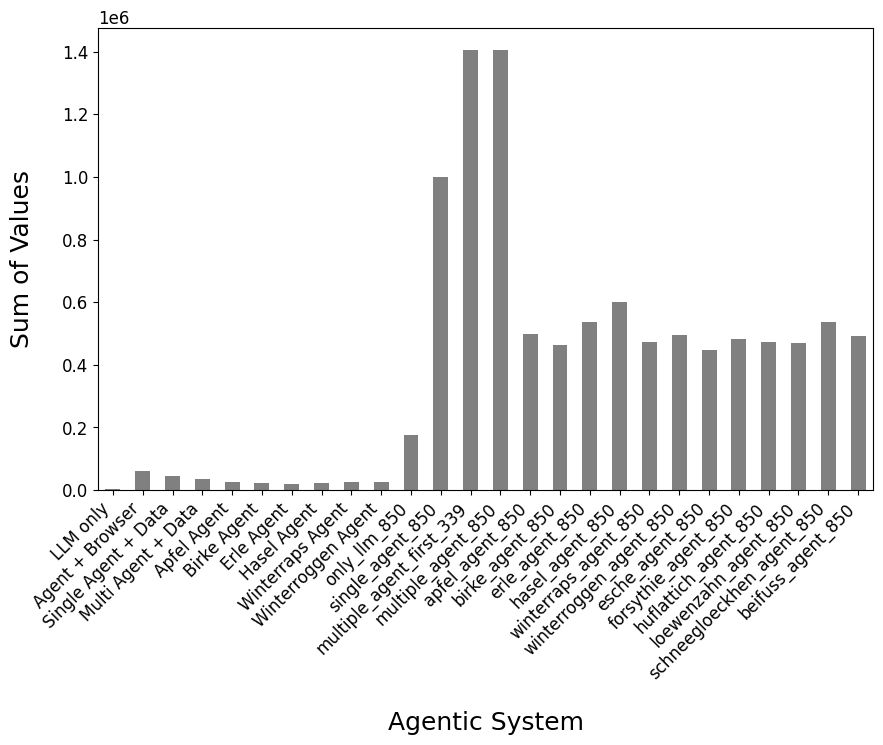

In [ ]:


df.sum(axis=0).plot(kind='bar', figsize=(10, 6), color='grey')
plt.xlabel("Agentic System", fontsize=18, labelpad=20)
plt.ylabel("Sum of Values", fontsize=18, labelpad=20)
#plt.title("Sum of Values per Agentic System", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()